# Forecast Apple Stock Price with ARIMA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
df = pd.read_csv('stock_px.csv', names=['Date', 'AAPL', 'MSFT', 'XOM', 'SPX'], skiprows=1)
df.head(3)

,Date,AAPL,MSFT,XOM,SPX
0,2003-01-02 00:00:00,7.40,21.11,29.22,909.03
1,2003-01-03 00:00:00,7.45,21.14,29.24,908.59
2,2003-01-06 00:00:00,7.45,21.52,29.96,929.01


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214 entries, 0 to 2213
Data columns (total 5 columns):
Date    2214 non-null object
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4), object(1)
memory usage: 86.6+ KB


In [4]:
df.set_index(pd.to_datetime(df['Date']), inplace=True)
del df['Date']
df.head(3)

,AAPL,MSFT,XOM,SPX
Date,,,,
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01


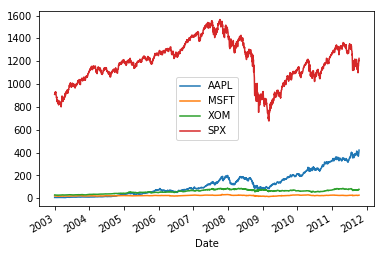

In [5]:
df.plot()

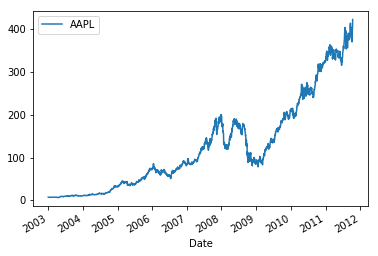

In [6]:
df.plot(y='AAPL')

#### We need to upsample to fill in some missing values! Because there's no stock price data for the weekends, bank holidays...

- freq are super powerful!

In [7]:
df2 = df.resample('d').interpolate().round(2)

In [8]:
df2['day']=df2.index.weekday_name
df2.head(10)

,AAPL,MSFT,XOM,SPX,day
Date,,,,,
2003-01-02,7.40,21.11,29.22,909.03,Thursday
2003-01-03,7.45,21.14,29.24,908.59,Friday
2003-01-04,7.45,21.27,29.48,915.40,Saturday
2003-01-05,7.45,21.39,29.72,922.20,Sunday
2003-01-06,7.45,21.52,29.96,929.01,Monday
2003-01-07,7.43,21.93,28.95,922.93,Tuesday
2003-01-08,7.28,21.31,28.83,909.93,Wednesday
2003-01-09,7.34,21.93,29.44,927.57,Thursday
2003-01-10,7.36,21.97,29.03,927.57,Friday


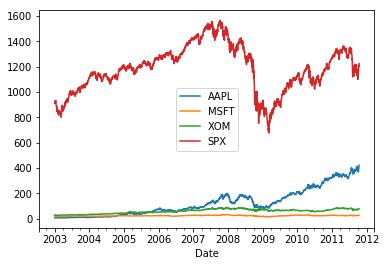

In [9]:
df2.plot()

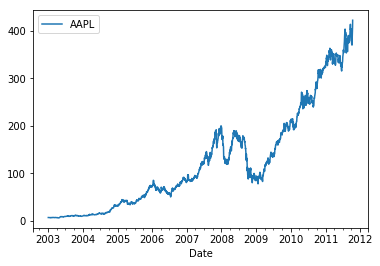

In [10]:
df2.plot(y = 'AAPL')

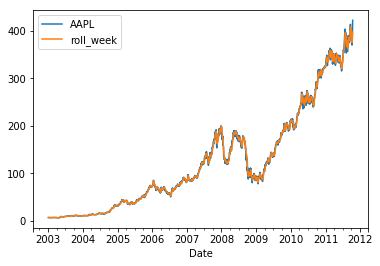

In [11]:
df2['roll_week'] = df2.rolling(window=7)['AAPL'].mean()
df2[['AAPL', 'roll_week']].plot()

#### It has smoothed out a fair bit, you can do that by changing the window to a month, or a year...

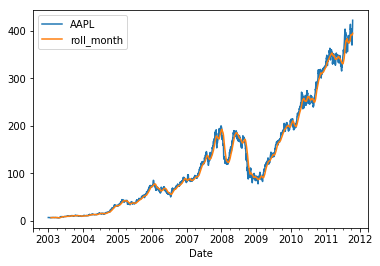

In [12]:
df2['roll_month'] = df2.rolling(window=30)['AAPL'].mean()
df2[['AAPL', 'roll_month']].plot()

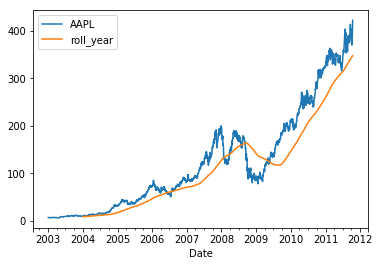

In [13]:
df2['roll_year'] = df2.rolling(window=365)['AAPL'].mean()
df2[['AAPL', 'roll_year']].plot()

#### Now let's remove the trend so we can start to get a stationary graph!
- We start by taking the difference:

In [15]:
df2['diff'] = df2['AAPL'].diff()
df2['pct'] = df2['AAPL'].pct_change()

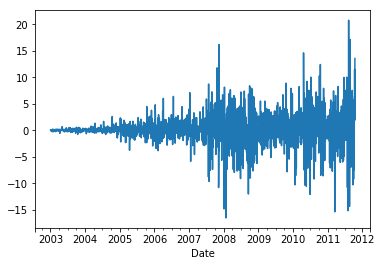

In [16]:
df2['diff'].plot() # this should have an autocorrelation

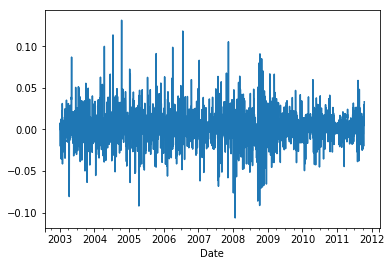

In [17]:
df2['pct'].plot() # this should have less autocorrelation

### Other options of transforming the data to remove trend/variation

- logarithm
- diff of diff
- Box-Cox transformation (see Forecasting book by Hyndman)

### Plot an autocorrelation and then we can start to work out an ARIMA model:

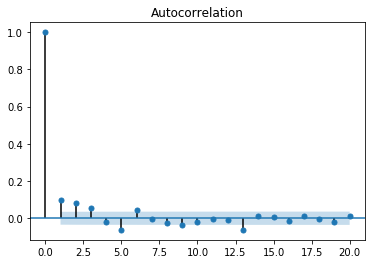

In [18]:
plot_acf(df2['diff'].dropna(), lags=20) 
# had to drop first value as it was NaN
None

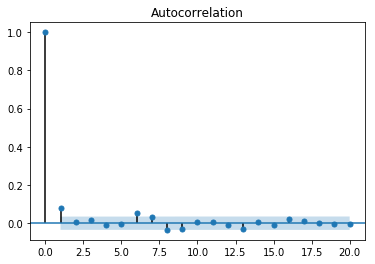

In [19]:
plot_acf(df2['pct'].dropna(), lags=20) 
# had to drop first value as it was NaN
None

#### pct is stationary and we can try and build an ARIMA model for it!

In [20]:
ytrain = df2['pct'].dropna().values[:2000]
ytest = df2['pct'].dropna().values[2000:]

m = ARIMA(ytrain, (2, 1, 2)) # has 3 hyperparameters    
m.initialize()
r = m.fit(maxiter=5000)

/Users/maximcondon/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
r.params

array([-3.79754753e-07, -9.10981215e-01,  5.98191911e-02, -1.99734618e-02,
       -9.80023088e-01])

[1950, 2050, -0.05, 0.05]

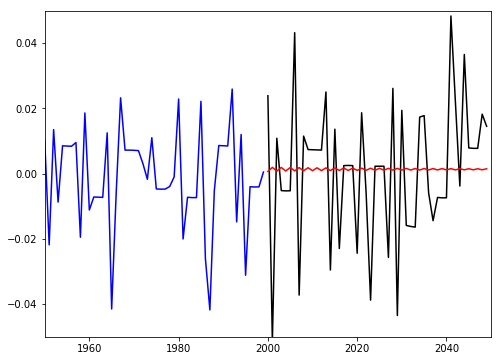

In [22]:
ypred, err, conf = r.forecast(steps = 50)

plt.figure(figsize=(8,6))
plt.plot(range(2000), ytrain, color = 'blue')

plt.plot(range(2000,2050), ytest[:50], color = 'black')

plt.plot(range(2000,2050), ypred, color = 'red')

plt.axis([1950,2050, -0.05, 0.05]) #use this to zoom in on a particular part of the graph!

#### This is a terrible prediction! Could try and play around with the hyperparameters.

In [23]:
ytrain = df2['pct'].dropna().values[:2000]
ytest = df2['pct'].dropna().values[2000:]

m = ARIMA(ytrain, (3, 0, 3)) # has 3 hyperparameters    
m.initialize()
r = m.fit(maxiter=5000)

[1900, 2050, -0.05, 0.05]

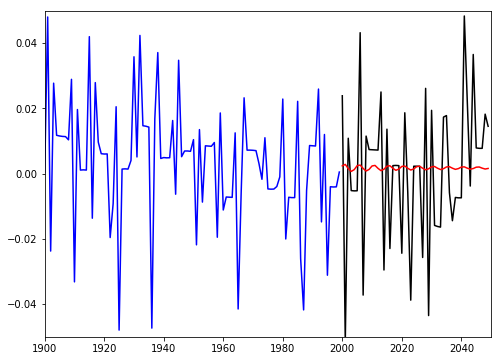

In [24]:
ypred, err, conf = r.forecast(steps = 50)

plt.figure(figsize=(8,6))
plt.plot(range(2000), ytrain, color = 'blue')

plt.plot(range(2000,2050), ytest[:50], color = 'black')

plt.plot(range(2000,2050), ypred, color = 'red')

plt.axis([1900,2050, -0.05, 0.05]) #use this to zoom in on a particular part of the graph!

#### Or it might be that filling in the days at the beginning for making our rolling average made our model worse!

In [25]:
df.shape

(2214, 4)

In [26]:
df['pct'] = df['AAPL'].pct_change()

In [27]:
ytrain = df['pct'].dropna().values[:2000]
ytest = df['pct'].dropna().values[2000:]

m = ARIMA(ytrain, (3, 1, 3)) # has 3 hyperparameters    
m.initialize()
r = m.fit(maxiter=5000)

/Users/maximcondon/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1900, 2050, -0.05, 0.05]

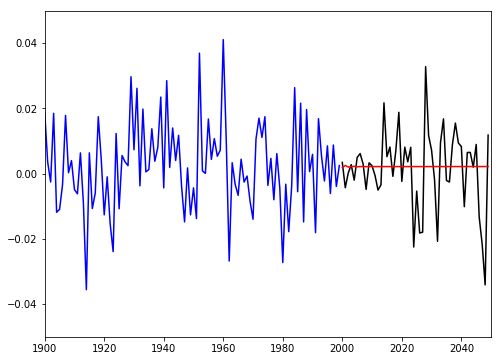

In [28]:
ypred, err, conf = r.forecast(steps = 50)

plt.figure(figsize=(8,6))
plt.plot(range(2000), ytrain, color = 'blue')

plt.plot(range(2000,2050), ytest[:50], color = 'black')

plt.plot(range(2000,2050), ypred, color = 'red')

plt.axis([1900,2050, -0.05, 0.05]) #use this to zoom in on a particular part of the graph!

Our model seems to be even worse!

/Users/maximcondon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maximcondon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maximcondon/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1900, 2050, -0.05, 0.05]

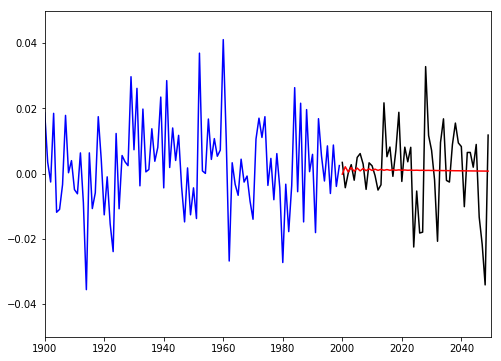

In [29]:
ytrain = df['pct'].dropna().iloc[1800:2000]
ytest = df['pct'].dropna().values[2000:]

m = ARIMA(ytrain, (3, 1, 2)) # has 3 hyperparameters    
m.initialize()
r = m.fit(maxiter=5000)

ypred, err, conf = r.forecast(steps = 50)

plt.figure(figsize=(8,6))
plt.plot(range(1800,2000), ytrain, color = 'blue')

plt.plot(range(2000,2050), ytest[:50], color = 'black')

plt.plot(range(2000,2050), ypred, color = 'red')

plt.axis([1900,2050, -0.05, 0.05]) #use this to zoom in on a particular part of the graph!

### Conclusions:

A simple ARIMA model is not suitable to predict the stock price for Apple, or in general for stocks!

### Recalculating growth to absolute value
- If I want to take my predictions and apply them to predict the future stock prices for Apple:

In [30]:
ypred + 1.0

array([0.9998706 , 1.00213495, 1.00054005, 1.00189727, 1.00075446,
       1.0017214 , 1.00087238, 1.00158577, 1.00095012, 1.00147921,
       1.00100207, 1.00139423, 1.00103529, 1.00132531, 1.00105462,
       1.0012684 , 1.00106358, 1.00122044, 1.0010648 , 1.00117917,
       1.00106024, 1.00114289, 1.00105137, 1.00111033, 1.00103927,
       1.00108056, 1.00102478, 1.00105287, 1.00100849, 1.00102673,
       1.00099086, 1.00100174, 1.00097223, 1.00097762, 1.00095285,
       1.00095414, 1.00093292, 1.00093115, 1.00091257, 1.00090851,
       1.00089191, 1.00088615, 1.00087102, 1.00086398, 1.00084995,
       1.00084196, 1.00082876, 1.00082006, 1.00080746, 1.00079824])

#### I would have to calculate the cumulative product!

In [31]:
newy = ypred + 1.0

newy[0] = 320.56 # next value

newdata = newy.cumprod()

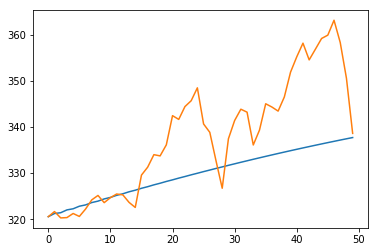

In [32]:
plt.plot(range(50), newdata)
plt.plot(range(50), df.iloc[2000:2050]['AAPL'])